In [1]:
from scipy import io
from pathlib import Path

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import optax

from collections import defaultdict
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from dynamax.hidden_markov_model import CircHMM
from dynamax.utils.plotting import gradient_cmap

from functools import partial
from sklearn.model_selection import train_test_split
from jax import vmap

2024-10-24 12:55:31.087403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 12:55:31.126762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 12:55:31.139165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 12:55:31.961379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
key = jr.PRNGKey(1)

total_trials = 10000
num_timesteps = 20

# Make an HMM and sample data and true underlying states
true_num_states = 2
emission_dim = 1
input_dim = 4

# Emission first and transition last in design matrix always
# how is input divided between transition and emission
emm_input_dim = 1
tr_input_dim = 3


hmm = CircHMM(true_num_states,
              input_dim,
              emission_dim,
              transition_matrix_concentration=2, 
              transition_matrix_stickiness= 10,
              tr_input_dim = tr_input_dim,
              emm_input_dim = emm_input_dim)


In [3]:
# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states

# transition_matrix = 0.1 * jr.normal(key, (true_num_states, true_num_states))
# transition_weights = 1 * jr.normal(key, (true_num_states, tr_input_dim))

# emission_weights = 0.1 * jr.normal(key, (true_num_states, emission_dim, emm_input_dim))
# emission_covs = jnp.tile(jnp.eye(emission_dim), (true_num_states, 1, 1))

In [4]:
transition_weights = jnp.array([
    [1, 1, -1],
    [-1, -1, 1]
])

transition_matrix = jnp.array([
    [0.8, 0.2],
    [0.4, 0.6]
])

In [5]:
emission_weights = jnp.array([
    [[1]],
    [[0.00001]]
])

emission_covs = jnp.array([
    [[1.]],
    [[100.]]
])

In [7]:
# visualize the true parameters for 2 states

feature_names = ["Focus", "Coherance", "Expectation"]
state_names = ["Bottom Up", "Top Down"]

def plot_transition_parameters(transition_matrix, transition_weights, feature_names, state_names):

    # make a 3x 2 grid of plots
    fig, axs = plt.subplots(3, 2, figsize=(10, 10), dpi=300)

    # for all subplots, draw a vertical line at x = 0
    # and write p(A) at the top of the line
    for ax in axs.flatten():
        ax.axvline(0, color='black', linewidth=0.5)
    # plot the probability of transitioning to other state as a function of the inputs


    # make p(x) = ax + b line
    x_axis = np.arange(-1, 1.1, 0.1)
    y_axis = lambda a, b: a * x_axis + b

    for goint_to_state in range(true_num_states):
        next_state = state_names[goint_to_state]
        axs[0, goint_to_state].title.set_text(f"Transition relation for \n next state {next_state}")

        for feature in range(tr_input_dim):
            
            # If you are currently in attentive state
            current_state = 0
            axs[feature, goint_to_state].plot(
                x_axis, 
                y_axis(transition_weights[goint_to_state, feature],
                    transition_matrix[current_state, goint_to_state]),
                "k--",
                alpha=0.5,
                label="Current State Bottom Up"
            )
            axs[feature, goint_to_state].text(0.5, 0.5, f"weight = {transition_weights[goint_to_state, feature]:.2f}\nbias = {transition_matrix[current_state, goint_to_state]:.2f}", fontsize=8, color="black")

            # If you are currently in inattentive state
            current_state = 1
            axs[feature, goint_to_state].plot(
                x_axis, 
                y_axis(transition_weights[goint_to_state, feature],
                    transition_matrix[current_state, goint_to_state]),
                "r-",
                alpha=0.5,
                label="Current State Top Down"
            )
            axs[feature, goint_to_state].text(0.5, .2, f"weight = {transition_weights[goint_to_state, feature]:.2f}\nbias = {transition_matrix[current_state, goint_to_state]:.2f}", fontsize=8, color="red")

            # print the gradient and y intercept
            axs[feature, goint_to_state].set_xlabel(f"Feature {feature_names[feature]}")
            axs[feature, goint_to_state].set_ylabel("logit(next state)")

            # add legend for current state
            axs[feature, goint_to_state].legend()

    plt.show()

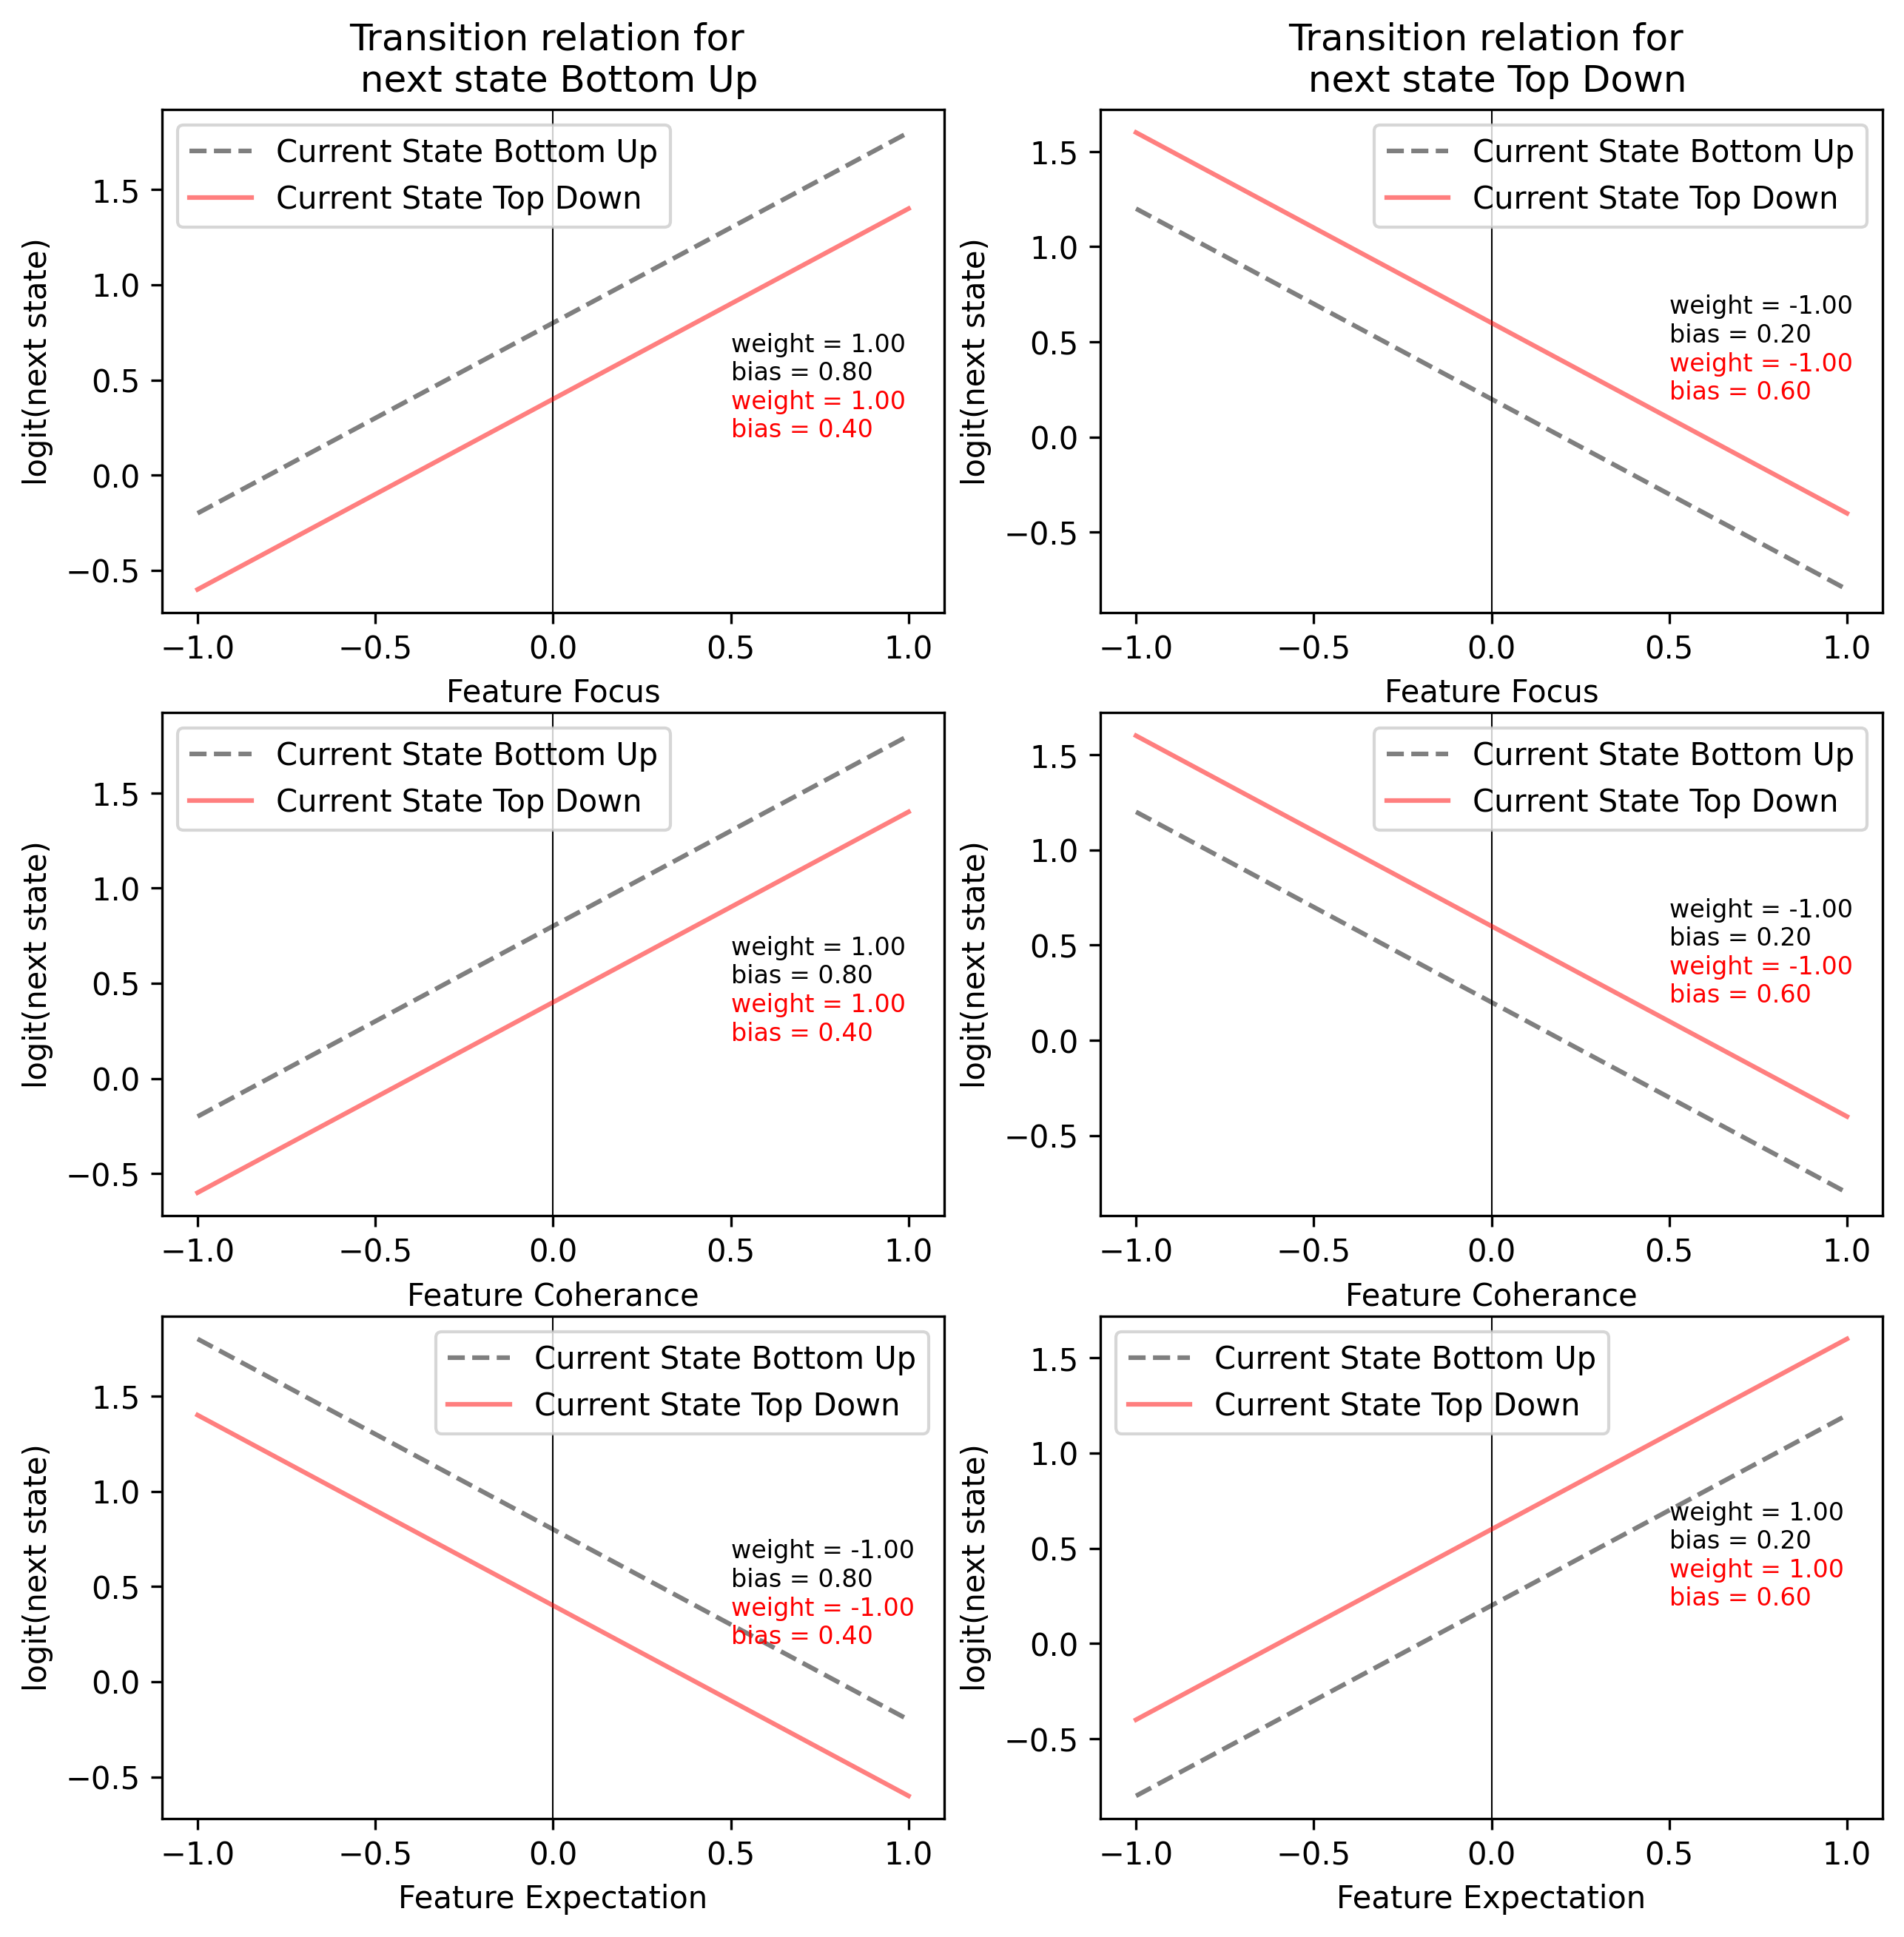

In [8]:
plot_transition_parameters(transition_matrix, transition_weights, feature_names, state_names)

In [8]:
true_params, _ = hmm.initialize(initial_probs=initial_probs,

                                transition_matrix=None,
                                transition_weights=transition_weights,

                                emission_weights=emission_weights,
                                emission_covariances=emission_covs)

In [9]:
true_params.transitions.transition_matrix.shape, \
true_params.transitions.transition_weights.shape, \
true_params.emissions.weights.shape, \
true_params.emissions.covs.shape

((2, 2), (2, 3), (2, 1, 1), (2, 1, 1))

In [10]:
# making inputs ["target", "focused", "coherance", "expectiation"]

targets = jr.uniform(key, 
                     shape=(total_trials, num_timesteps,1), 
                     minval=-jnp.pi, 
                     maxval=jnp.pi)

# focused is -1 or 1 choose it randomly
focused = jr.bernoulli(key, 
                       p = 0.5, 
                       shape=(total_trials, num_timesteps,1)) * 2 - 1

# coherance is -1 to 1
coherance = jr.uniform(key, 
                       shape=(total_trials, num_timesteps,1), 
                       minval=-1, 
                       maxval=1)

# expectation is -1 or 1
expectation = jr.bernoulli(key, 
                           p = 0.5, 
                           shape=(total_trials, num_timesteps,1)) * 2 - 1

inputs = jnp.concatenate([targets, focused, coherance, expectation], axis=-1)

In [11]:
# sklearn train test split

train_trials = int(total_trials * 0.7)
test_traials = total_trials - train_trials

train_inputs, test_inputs = train_test_split(inputs, test_size=test_traials/total_trials, random_state=42)
train_inputs.shape, test_inputs.shape

((7000, 20, 4), (3000, 20, 4))

In [12]:
# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)

# Split keys for each batch
train_keys = jr.split(train_key, train_trials)
test_keys = jr.split(test_key, test_traials)

# Define a function that samples given an input and key
def sample_fn(key, inputs):
    return hmm.sample(true_params, num_timesteps=num_timesteps, inputs=inputs, key=key)

# Vectorize the sampling over batches using vmap
train_true_states, train_emissions = vmap(sample_fn)(train_keys, train_inputs)
test_true_states, test_emissions = vmap(sample_fn)(test_keys, test_inputs)

In [13]:
train_emissions.shape, test_emissions.shape

((7000, 20, 1, 1), (3000, 20, 1, 1))

In [14]:
# Initialize the parameters using K-Means on the full training set
test_hmm = CircHMM(2, 
                   input_dim, 
                   emission_dim, 
                   transition_matrix_concentration=2, 
                   transition_matrix_stickiness= 10,
                   tr_input_dim = tr_input_dim,
                   emm_input_dim = emm_input_dim)

params, props = test_hmm.initialize(key=jr.PRNGKey(0))

params, lps = test_hmm.fit_sgd( params = params, 
                                props = props, 
                                emissions = train_emissions.reshape(train_trials,num_timesteps,1), 
                                inputs = train_inputs, 
                                num_epochs = 5000, 
                                optimizer = optax.adam(1e-3), 
                                shuffle = False,
                                batch_size = 32)

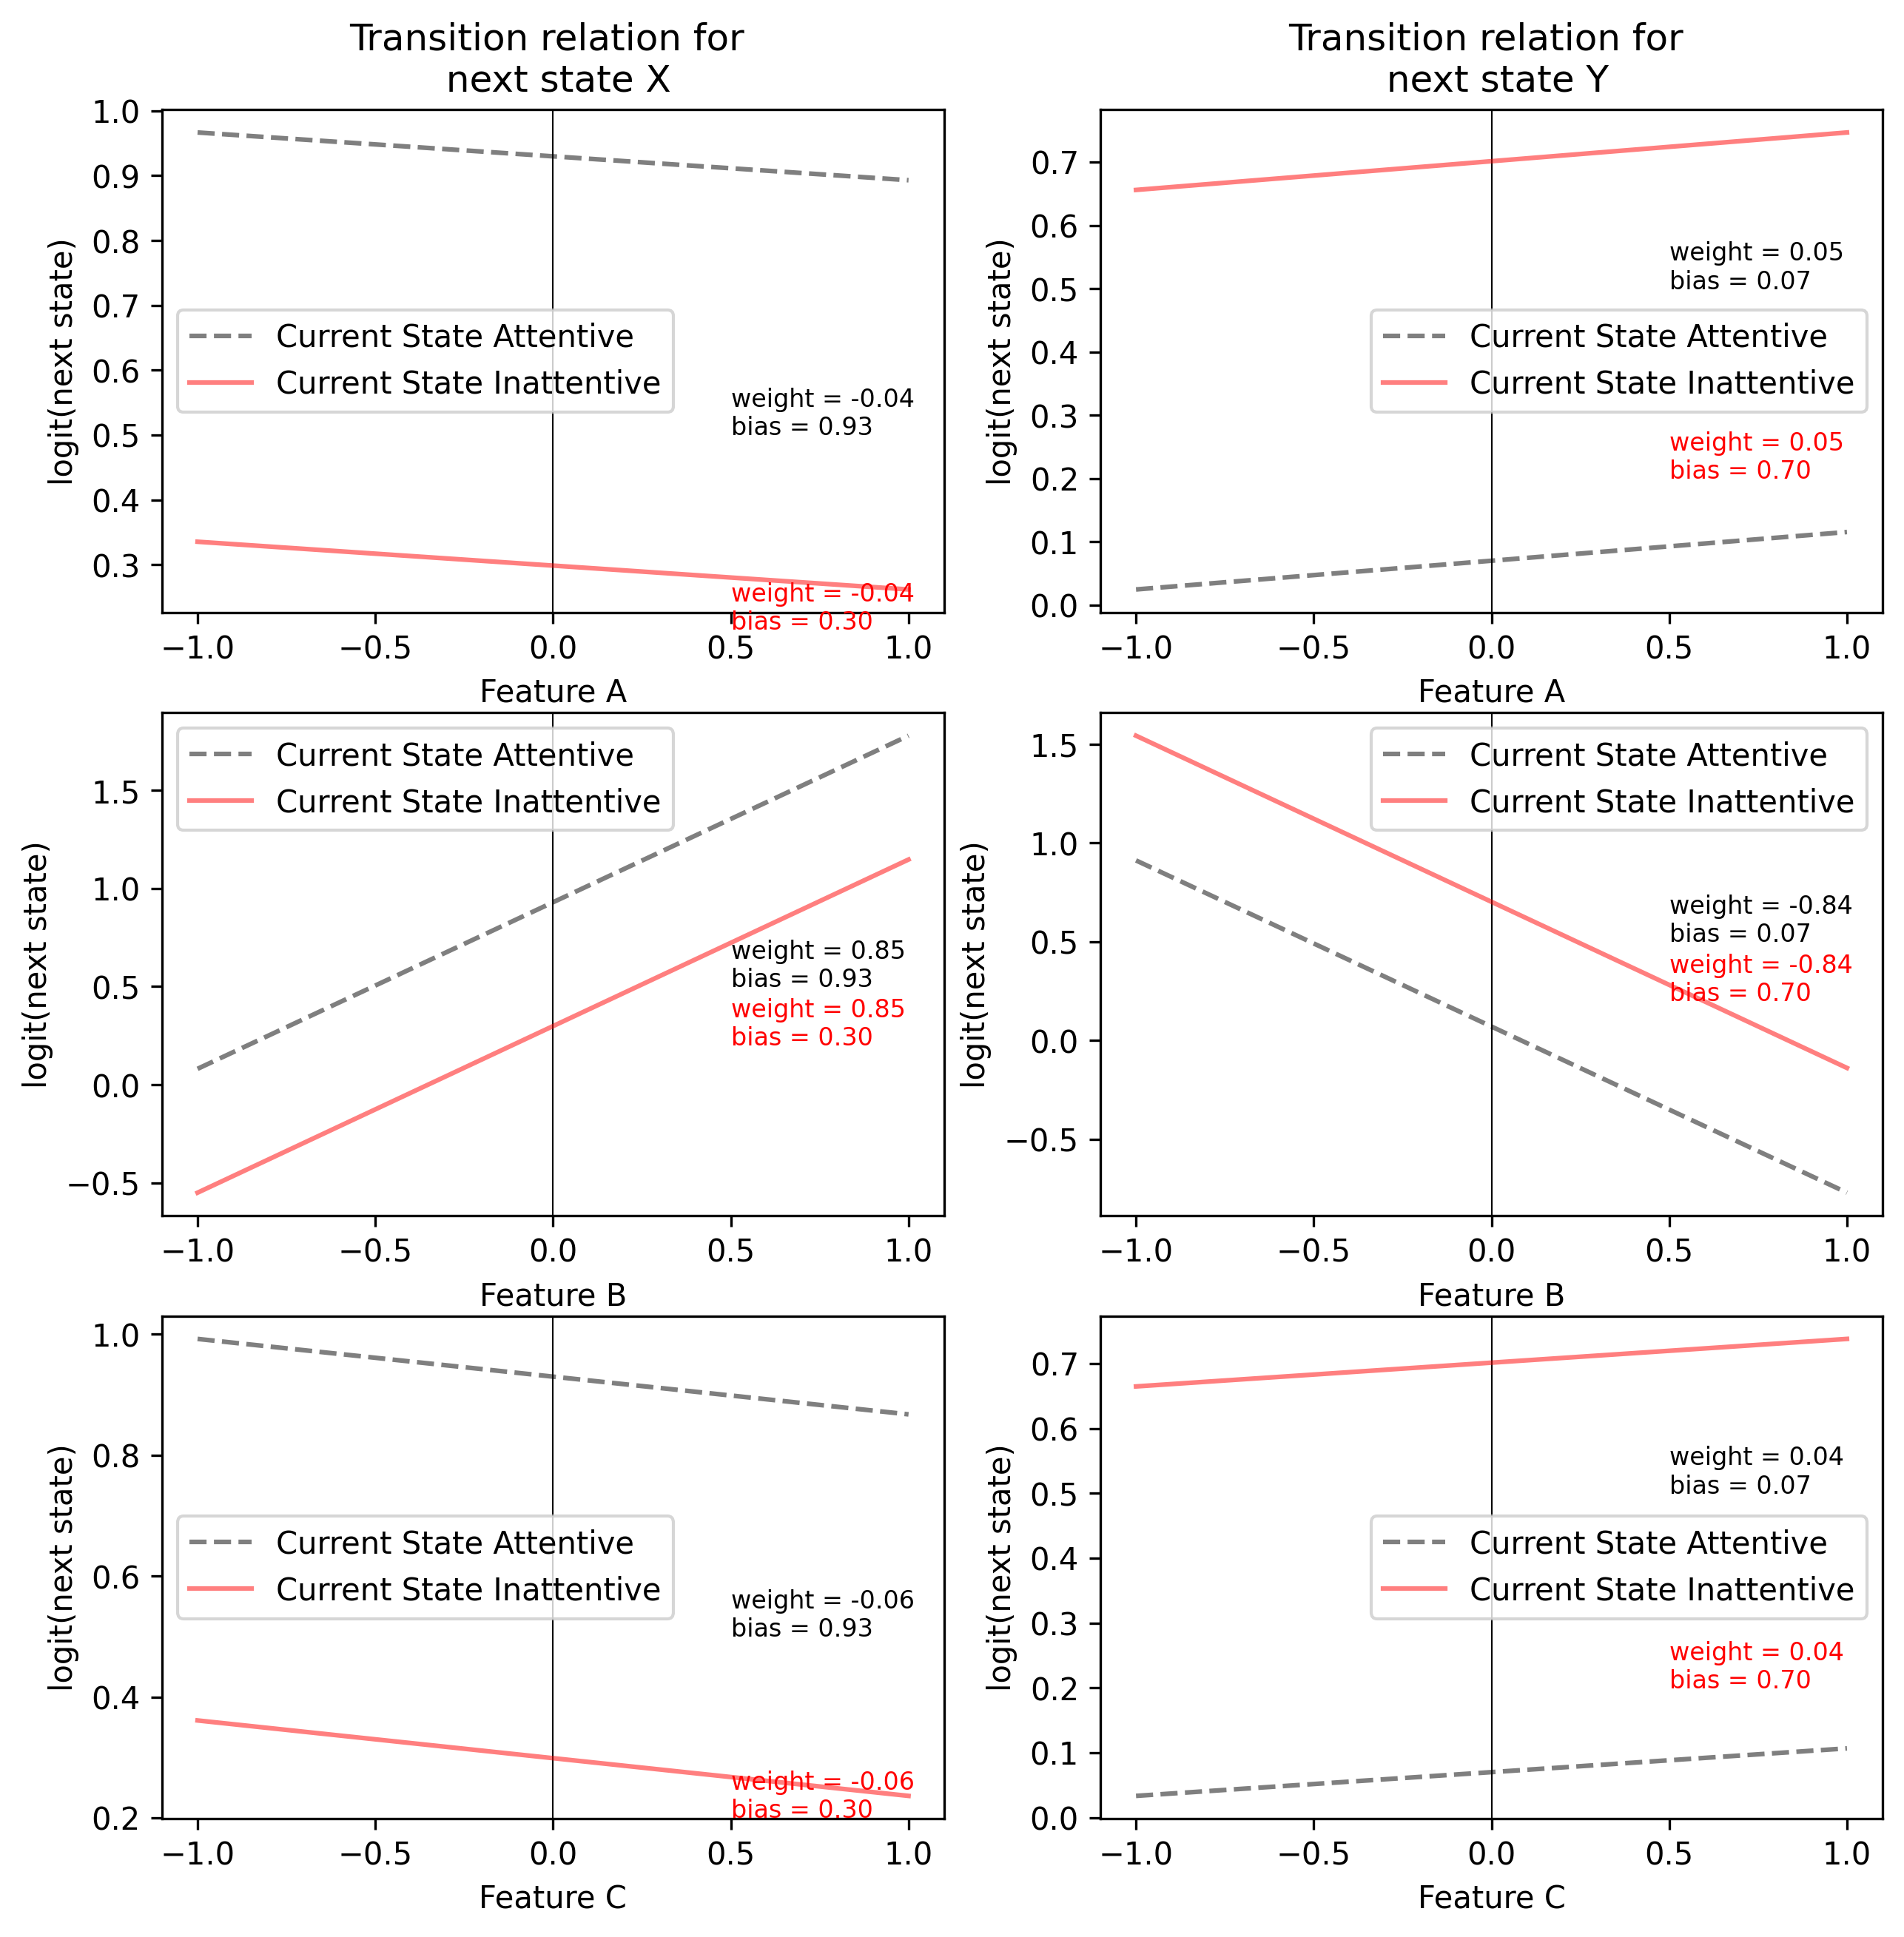

In [23]:

plot_transition_parameters(true_params.transitions.transition_matrix, 
                           params.transitions.transition_weights, 
                           ['A', 'B', 'C'], # feature names
                           ['X', 'Y']) # state names

Text(0.5, 1.0, 'Training convergence')

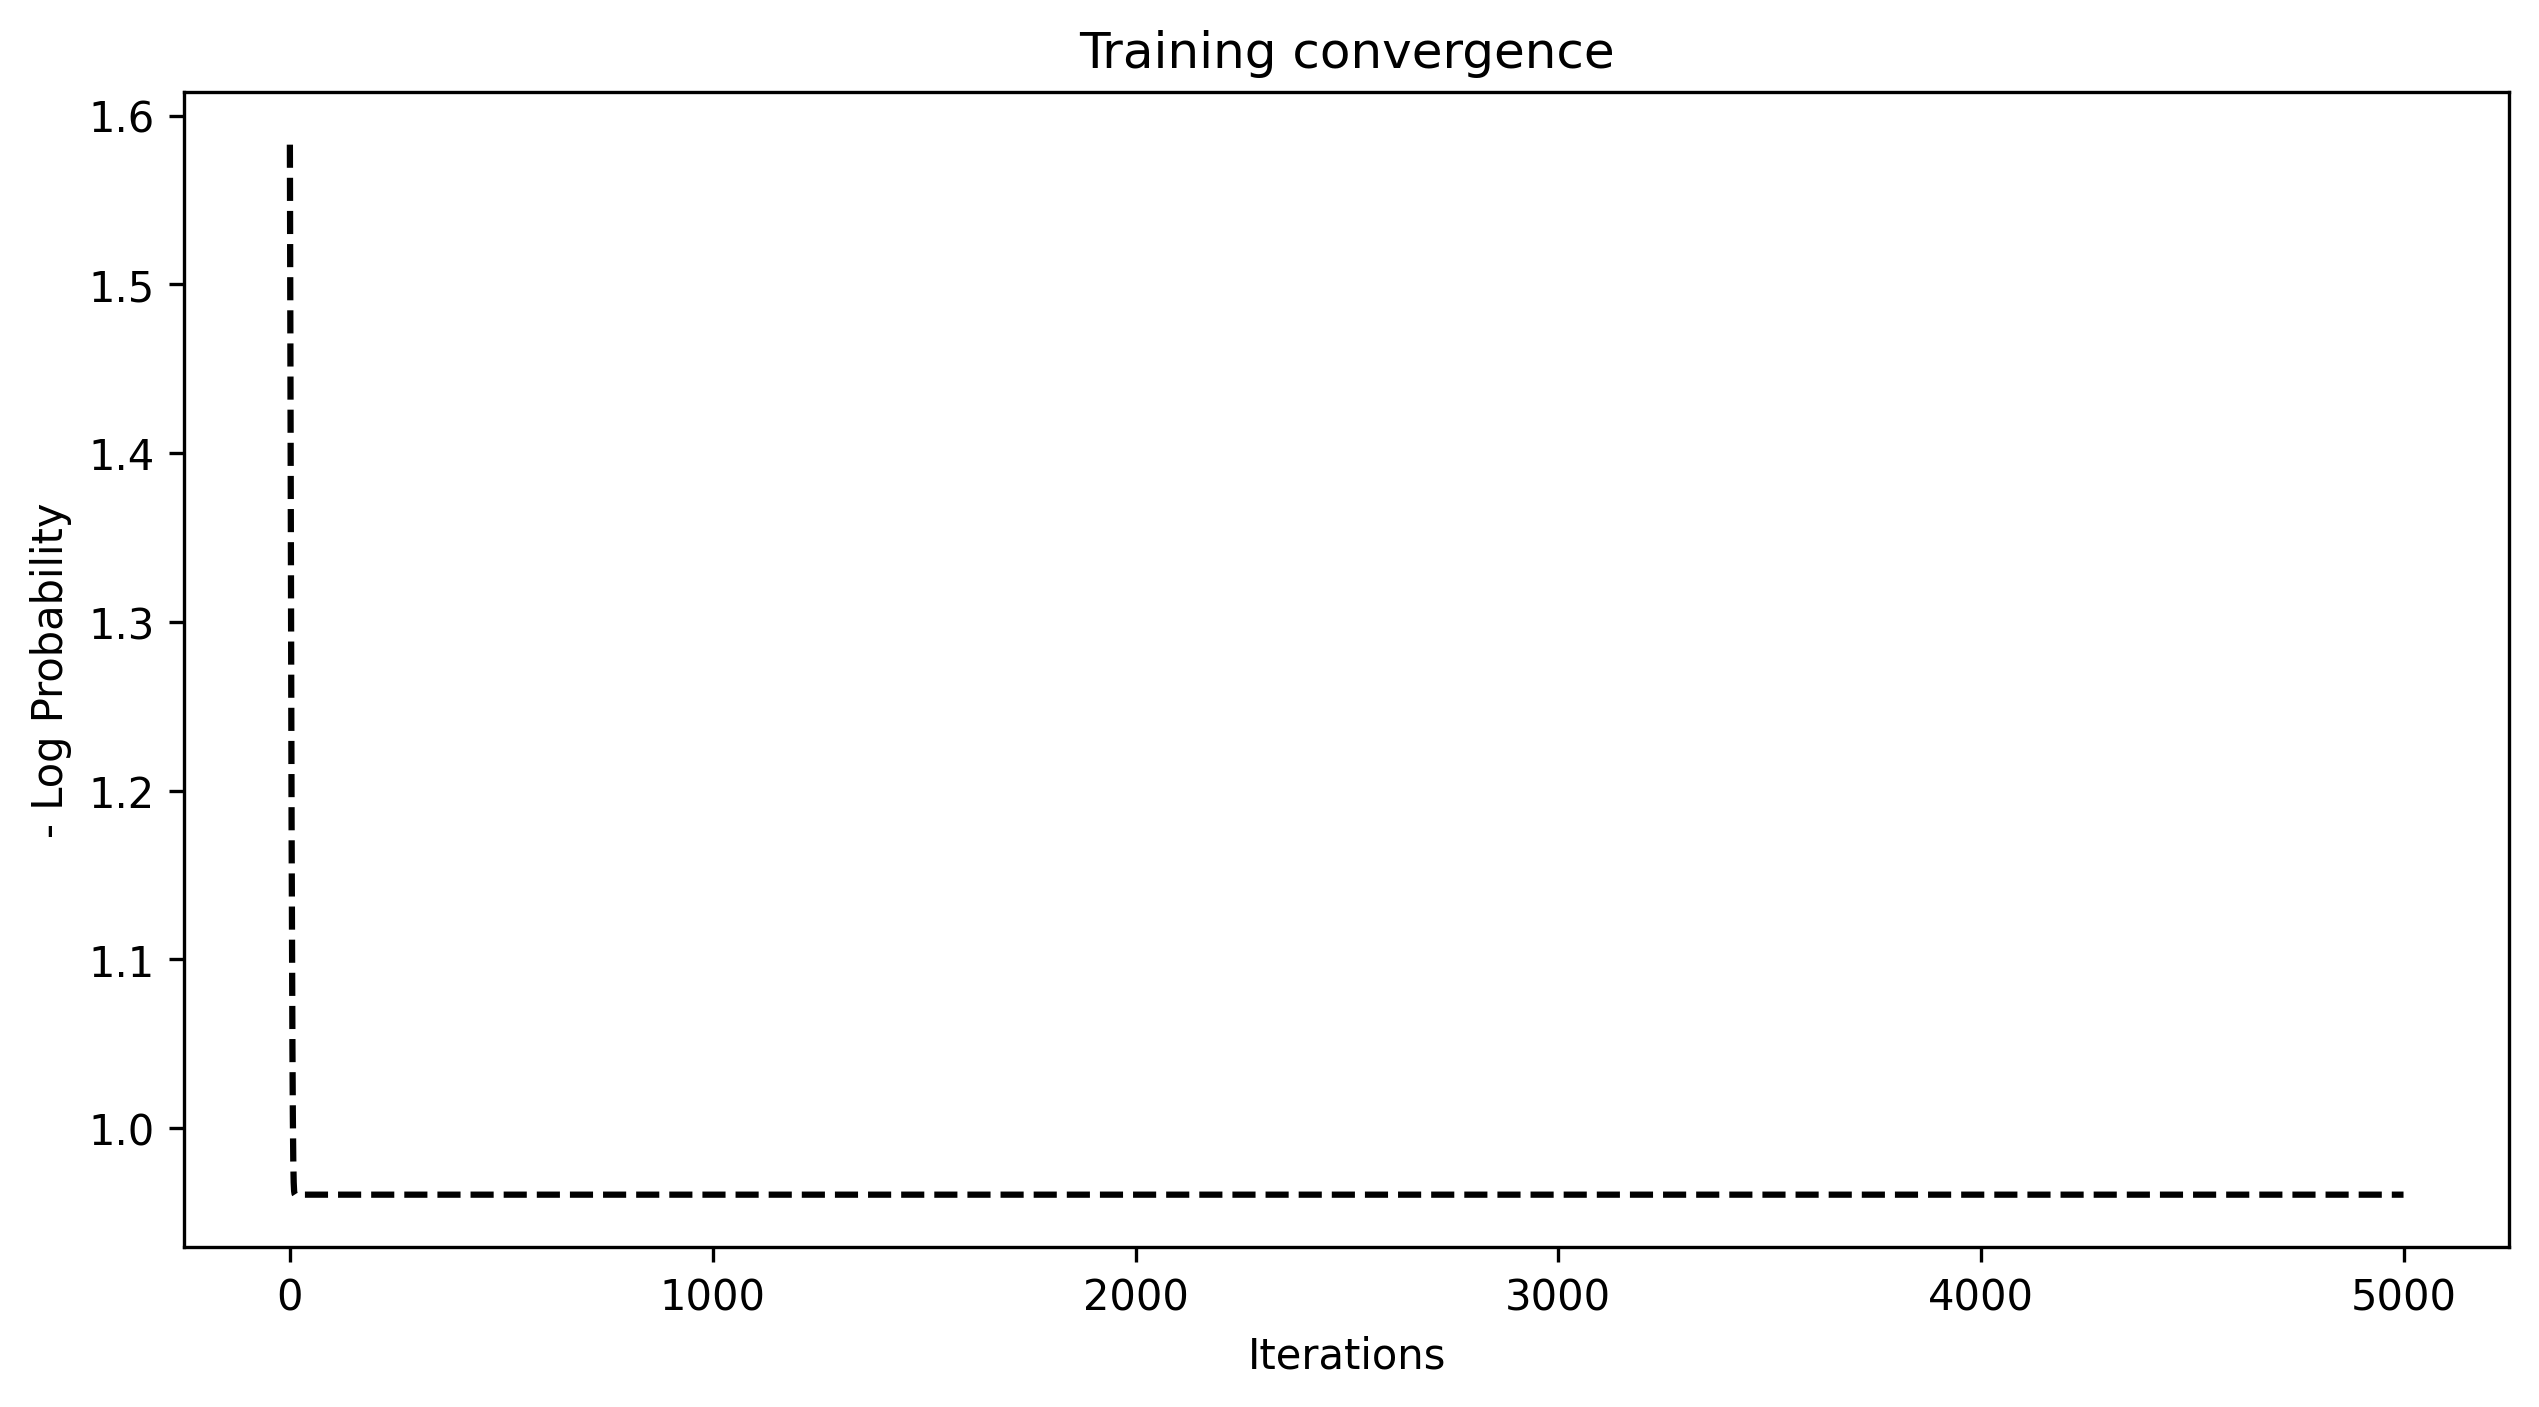

In [37]:

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(lps, "k--")
plt.xlabel("Iterations")
plt.ylabel("- Log Probability")
plt.title("Training convergence")
# plt.ylim(0,2)


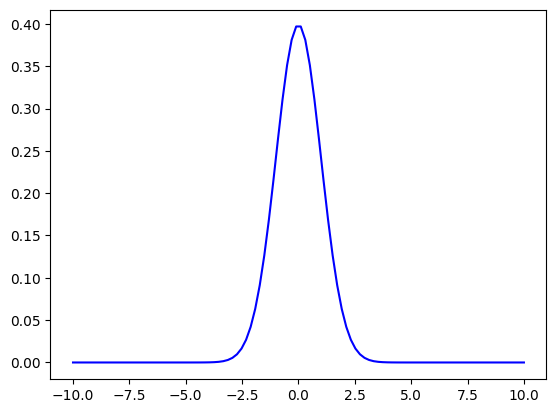

In [39]:
# make a function to plot 2 normal distributions given their mean and covariance
def plot_normal(mean, cov, color):
    x = np.linspace(-10, 10, 100)
    y = np.exp(-0.5 * (x - mean) ** 2 / cov) / np.sqrt(2 * np.pi * cov)
    plt.plot(x, y, color=color)

plot_normal(0, 1, "blue")

In [40]:
emission_weights

Array([[[1.e+00]],

       [[1.e-05]]], dtype=float32)

In [42]:
emission_weights.flatten()


Array([1.e+00, 1.e-05], dtype=float32)

In [ ]:
# plot a normal GLM given the weights and variance
plt.figure(figsize=(10, 5), dpi=300)




In [15]:
params.initial

ParamsStandardHMMInitialState(probs=Array([0.38526455, 0.6147354 ], dtype=float32))

In [16]:
true_params.initial

ParamsStandardHMMInitialState(probs=Array([0.5, 0.5], dtype=float32))

In [17]:
params.emissions

ParamsCircEmissions(weights=Array([[[ 1.0112777 ]],

       [[-0.00140535]]], dtype=float32), covs=Array([[[ 0.8055044]],

       [[99.66497  ]]], dtype=float32))

In [18]:
true_params.emissions

ParamsCircEmissions(weights=Array([[[1.e+00]],

       [[1.e-05]]], dtype=float32), covs=Array([[[  1.]],

       [[100.]]], dtype=float32))

In [19]:
params.transitions.transition_weights

Array([[-0.03680265,  0.84882396, -0.06240361],
       [ 0.04538602, -0.84067494,  0.03662695]], dtype=float32)

In [20]:
true_params.transitions.transition_matrix

Array([[0.9298944 , 0.0701056 ],
       [0.29870945, 0.7012905 ]], dtype=float32)

In [21]:
params.transitions.transition_weights

Array([[-0.03680265,  0.84882396, -0.06240361],
       [ 0.04538602, -0.84067494,  0.03662695]], dtype=float32)

In [22]:
true_params.transitions.transition_weights

Array([[ 1,  1, -1],
       [-1, -1,  1]], dtype=int32)